# Focused Analysis

In our exploratory analysis, we looked at various views of data to find some interesting questions we wanted to ask about pothole complaints in 311 and how those complaints were handled by the DOT.  We came up with two specific ideas to investigate more closely:

* Is Staten Island experiencing statistically significant longer resolution times?
* Is response time disparity per borough getting better over time?

Let's bring in our cleaned and prepared data and take a closer look!  Because we're interested in borough-to-borough comparisons, we'll eliminate rows that have "Unspecified" boroughs.

In [1]:
import pandas as pd
potholes = pd.read_csv('../data/updated_potholes_data.csv')
for col in ['created_date', 'resolved_date']:
    potholes[col] = pd.to_datetime(potholes[col])
potholes.drop(potholes[potholes['borough'] == "Unspecified"].index, inplace = True)
potholes.head()

,created_date,complaint_type,incident_zip,cross_street_1,cross_street_2,address_type,city,status,community_board,borough,open_data_channel_type,park_borough,latitude,longitude,resolved_date,days_to_close,shorter_description,year
0,2016-11-01 15:01:46,Street Condition,NaN,AVENUE M,AVENUE N,BLOCKFACE,NaN,Closed,Unspecified BROOKLYN,BROOKLYN,UNKNOWN,BROOKLYN,NaN,NaN,2016-11-02 09:45:00,1.0,Repaired: Inspected and Repaired,2016
1,2019-04-01 22:22:27,Street Condition,10306.0,JACQUES AVENUE,NEW DORP LANE,ADDRESS,STATEN ISLAND,Closed,02 STATEN ISLAND,STATEN ISLAND,UNKNOWN,STATEN ISLAND,40.572961,-74.113157,2019-04-02 10:51:00,1.0,Not Repaired: Did Not Find,2019
2,2013-01-09 11:20:10,Street Condition,NaN,DELANCEY STREET,WILLIAMSBURG BRIDGE,BLOCKFACE,NEW YORK,Closed,Unspecified MANHATTAN,MANHATTAN,UNKNOWN,MANHATTAN,NaN,NaN,2013-01-10 14:04:00,1.0,Repaired: Inspected and Repaired,2013
3,2013-01-10 14:45:07,Street Condition,11101.0,40 AVENUE,41 AVENUE,BLOCKFACE,Long Island City,Closed,Unspecified QUEENS,QUEENS,UNKNOWN,QUEENS,NaN,NaN,2013-01-11 10:20:00,1.0,Repaired: Inspected and Repaired,2013
4,2019-03-29 07:05:49,Street Condition,10025.0,WEST 105 STREET,WEST 106 STREET,ADDRESS,NEW YORK,Closed,07 MANHATTAN,MANHATTAN,UNKNOWN,MANHATTAN,40.798200,-73.961809,2019-03-30 20:00:00,1.0,Repaired: Inspected and Repaired,2019


As a reminder, let's take a peek at the exploratory visualization that made us recognize that Staten Island stood out as having longer response times:

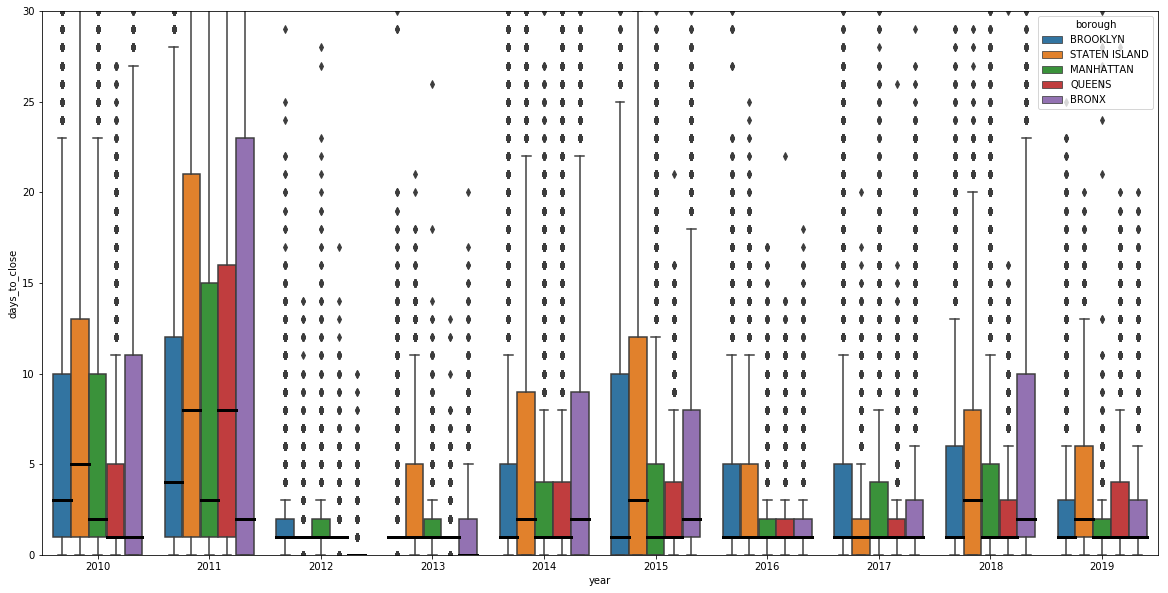

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.ylim(0, 30)
medianprops = dict(linewidth=3, color='black')
sns.boxplot(x="year", hue="borough", y="days_to_close", data=potholes, **{'medianprops':medianprops})

## Statistical Analysis

First, let's ask some statistical questions: 

First, looking at all the data without regard for when the complaint was initiated:

* **Question 1:** Overall, regardless of year, does a disparity exist between boroughs with regard to pothole complaint resolutions?
* **Question 2:** Overall, regardless of year, has Staten Island experienced longer wait times for complaint resolutions than the other boroughs?

We'll want to measure not only p values, but also effect sizes, where applicable.  So let's add a small function to figure out Cohen's d:

In [3]:
from numpy import var, mean
from math import sqrt
def cohens_d (first, second):
  s1, s2 = var(first, ddof=1), var(second, ddof=1)
  # calculate pooled standard deviation
  std = sqrt(((len(first) - 1) * s1 + (len(second) - 1) * s2) / (len(first) + len(second) - 2))
  return (mean(first)-  mean(second)) / std

### Question 1

Let's consider our first statistical question:

> Overall, regardless of year, does a disparity exist between boroughs with regard to pothole complaint resolutions?

This calls for an ANOVA.  Is there a real difference between boroughs?  Keep in mind this will only tell us if there is a disparity, not which two or more boroughs are indicated as being disparate.  We'll create a copy of `potholes` that only includes the borough identifier and the number of days to close.  We'll remove any rows that lack data.

Then we'll perform an ANOVA, or analysis of variance.

In [4]:
from scipy import stats
potholes_simple = potholes[['days_to_close', 'borough']].dropna()


stats.f_oneway(potholes_simple[['days_to_close']][potholes_simple['borough'] == "BRONX"],
              potholes_simple[['days_to_close']][potholes_simple['borough'] == "BROOKLYN"],
              potholes_simple[['days_to_close']][potholes_simple['borough'] == "MANHATTAN"],
              potholes_simple[['days_to_close']][potholes_simple['borough'] == "QUEENS"],
              potholes_simple[['days_to_close']][potholes_simple['borough'] == "STATEN ISLAND"])

F_onewayResult(statistic=array([1772.04548406]), pvalue=array([0.]))

We get a very high F statistic and very low p value, which indicates that these five groups are not equal when it comes to response time.  The difference among the groups could only with extreme doubt (approaching nearly impossible) be attributed to chance.  There is a difference, some sort of inequality.  Pothole complaints have different response times in the different boroughs.  The difference we saw in our various data visualizations have been substantiated statistically.

### Question 2

To determine whether Staten Island has a statistically significant difference in response time compared to the other boroughs, we can do a two-sample independent T test.  While the distribution of response time (`days_to_close`) is not normal (in every case we have some long outliers), we have enough data that the two-sample independent T test should be robust to non-normality.

In [5]:
potholes_simple['Staten Island'] = potholes_simple['borough'] == "STATEN ISLAND"
stats.ttest_ind(potholes_simple[['days_to_close']][potholes_simple['Staten Island']], 
                potholes_simple[['days_to_close']][~potholes_simple['Staten Island']])

Ttest_indResult(statistic=array([59.48866997]), pvalue=array([0.]))

What about effect size?

In [6]:
cohens_d(potholes_simple[['days_to_close']][potholes_simple['Staten Island']], 
                potholes_simple[['days_to_close']][~potholes_simple['Staten Island']])

days_to_close    0.225678
dtype: float64

The effect size is small to medium, while the p value is extremely small (rounding to 0).  The small p value tells us that there is a difference in observed Staten Island response times (it takes longer to resolve a Staten Island pothole complaint), and that difference seems to not be explained away by random chance.

The small Cohen's d (effect size) tells us that the difference itself between Staten Island and other boroughs is small, when compared to the overall variation in response time generally.  

What **is** the difference?  Let's compare means and medians:

In [7]:
print("Staten Island mean response time (days): ", 
      potholes_simple[['days_to_close']][potholes_simple['Staten Island']].mean())
print("Other boroughs mean response time (days): ", 
      potholes_simple[['days_to_close']][~potholes_simple['Staten Island']].mean())

Staten Island mean response time (days):  days_to_close    6.013254
dtype: float64
Other boroughs mean response time (days):  days_to_close    4.169855
dtype: float64


In [8]:
print("Staten Island median response time (days): ", 
      potholes_simple[['days_to_close']][potholes_simple['Staten Island']].median())
print("Other boroughs median response time (days): ", 
      potholes_simple[['days_to_close']][~potholes_simple['Staten Island']].median())

Staten Island median response time (days):  days_to_close    2.0
dtype: float64
Other boroughs median response time (days):  days_to_close    1.0
dtype: float64


While the effect size is small, that's because the effect is being measured against overall variance in response time, which is pretty big (after all, there are some tickets that aren't dealt with for hundreds of days).  In this case, the human effect size is pretty big: 2 days in mean, or about an additional 50% wait time, and 1 day in median, or double the wait time.  The average Staten Island pothole complaint (whether we consider the mean or the median) has a considerably longer time until resolution, and this is statistically significant at a very low p value.   Let's demonstrate that graphically.

First, let's look at the entire dataset, including unrealistic outliers:

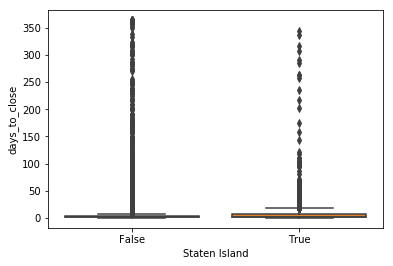

In [9]:
sns.boxplot(x="Staten Island", y="days_to_close", data = potholes_simple)

As we can see, the difference between these two distributions is so small as to be impossible to show.  Thus, the effect size is tiny.  But if we zoom in to where the actual bulk of pothole resolutions are taking place (within 2 weeks), we see something much different:

(0, 20)

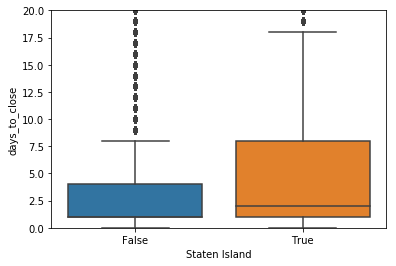

In [10]:
sns.boxplot(x="Staten Island", y="days_to_close", data = potholes_simple)
plt.ylim(0, 20)

### Question 3

Let's also consider year-over-year performance.  Are disparities getting better as time goes on?

**Question 3:** Is disparity among boroughs improving over time?

For this question, we can look at the F statistic year over year, as well as the range of days to close pothole complaints.

In [42]:
mean_ranges = []
overall_means = []
median_ranges = []
overall_medians = []
overall_sd = []
f_stats = []
p_stats = []

for year in range(2010,2020):
    potholes_year = potholes[['days_to_close', 'borough']][potholes['year'] == year].dropna()
    f, p = stats.f_oneway(potholes_year[['days_to_close']][potholes_year['borough'] == "BRONX"],
              potholes_year[['days_to_close']][potholes_year['borough'] == "BROOKLYN"],
              potholes_year[['days_to_close']][potholes_year['borough'] == "MANHATTAN"],
              potholes_year[['days_to_close']][potholes_year['borough'] == "QUEENS"],
              potholes_year[['days_to_close']][potholes_year['borough'] == "STATEN ISLAND"])
    p_stats += [p[0]] 
    f_stats += [f[0]]
    potholes_year_mean = potholes_year.groupby('borough')['days_to_close'].mean()
    potholes_year_median = potholes_year.groupby('borough')['days_to_close'].median()
    mean_range = max(potholes_year_mean) - min(potholes_year_mean)
    median_range = max(potholes_year_median) - min(potholes_year_median)
    mean_ranges += [mean_range]
    median_ranges += [median_range]
    overall_means += [potholes_year['days_to_close'].mean()]
    overall_medians += [potholes_year['days_to_close'].median()]
    overall_sd += [potholes_year['days_to_close'].std()]

disparity_data = pd.DataFrame({'year' : range(2010,2020), 
                               'p_stat' : p_stats,
                               'f_stat' : f_stats,
                               'overall_sd' : sd_stats,
                               'overall_mean' : overall_means,
                               'mean_range' : mean_ranges,
                               'overall_median' : overall_medians,
                               'median_range' : median_ranges})
disparity_data['means_disparity'] = disparity_data['mean_range']/disparity_data['overall_mean']
disparity_data['medians_disparity'] = disparity_data['median_range']/disparity_data['overall_median']

disparity_data
    

,year,p_stat,f_stat,overall_sd,overall_mean,mean_range,overall_median,median_range,means_disparity,medians_disparity
0,2010,0.000000e+00,598.614509,8.454806,6.005294,4.776284,2.0,4.0,0.795346,2.0
1,2011,7.325690e-243,284.703684,13.493647,10.438648,5.617601,5.0,6.0,0.538154,1.2
2,2012,1.936590e-98,115.930082,5.929163,1.616676,1.830922,1.0,1.0,1.132523,1.0
3,2013,0.000000e+00,398.128441,3.298482,1.672042,1.982679,1.0,1.0,1.185783,1.0
4,2014,1.988019e-255,298.715674,10.045772,5.379231,3.351781,1.0,1.0,0.623097,1.0
5,2015,0.000000e+00,902.754211,7.135123,4.723241,3.905609,1.0,2.0,0.826892,2.0
6,2016,0.000000e+00,435.743596,5.010870,2.454789,2.010138,1.0,0.0,0.818864,0.0
7,2017,0.000000e+00,516.907483,4.746244,2.713484,2.313902,1.0,0.0,0.852742,0.0
8,2018,0.000000e+00,469.146682,6.803077,3.892071,3.196957,1.0,2.0,0.821402,2.0
9,2019,2.829997e-44,52.618366,4.732564,2.809060,1.301139,1.0,1.0,0.463194,1.0


It certainly seems that we are, writ large, tending toward less disparity between boroughs, comparing earlier years to later years.  Overall standard deviation (across boroughs) is trending lower, as is the range of mean response times per borough.  Still, this trend is not monotonic (consistently going down each year), but fluctuates.